In [1]:
!nvidia-smi

Thu Feb  6 15:30:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.08             Driver Version: 550.127.08     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100S-PCIE-32GB          On  |   00000000:81:00.0 Off |                    0 |
| N/A   28C    P0             24W /  250W |       1MiB /  32768MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import flair
import matplotlib.pyplot as plt
import os
import pandas as pd

from codealltag_data_processor_v2025 import CodealltagDataProcessor
from flair.data import Corpus, Dictionary, Sentence
from flair.datasets import ColumnCorpus
from flair.embeddings import (
    BytePairEmbeddings,
    StackedEmbeddings,
    TokenEmbeddings,
    TransformerWordEmbeddings,
    WordEmbeddings    
)
from flair.models import SequenceTagger
from flair.nn import Model
from flair.trainers import ModelTrainer
from pathlib import Path

In [3]:
flair.cache_root = Path(os.path.join(*['/home', 's81481', '.flair']))

In [4]:
cdp_2022 = CodealltagDataProcessor(data_version='20220513', config_path=['codealltag_data_processor.yml'])
cdp_2020 = CodealltagDataProcessor(data_version='20200518', config_path=['codealltag_data_processor.yml'])

In [5]:
sample_size = 10_000
k = 5

In [6]:
model_dir_path = os.path.join(*["logs", "GELECTRA", "NER", str(sample_size//1000)+"K", "k"+str(k)])
os.makedirs(model_dir_path, exist_ok=True)

In [7]:
dataset = cdp_2022.get_train_dev_test_datasetdict_for_sample_size(cdp_2020, sample_size, k)

In [8]:
tmp_data_dir = Path("tmp_data_dir")
tmp_data_dir.mkdir(parents=True, exist_ok=True)
for file in tmp_data_dir.glob("*"):
    if file.is_file():
        file.unlink()

In [9]:
train_df = dataset["train"].to_pandas()
dev_df = dataset["dev"].to_pandas()
test_df = dataset["test"].to_pandas()

In [10]:
train_text = train_df.InputType1.str.cat(sep="\n")
dev_text = dev_df.InputType1.str.cat(sep="\n")
test_text = test_df.InputType1.str.cat(sep="\n")

In [11]:
with open(os.path.join(tmp_data_dir, "train.txt"), "w", encoding="utf-8") as writer:        
    writer.write(train_text)

with open(os.path.join(tmp_data_dir, "dev.txt"), "w", encoding="utf-8") as writer:        
    writer.write(dev_text)
    
with open(os.path.join(tmp_data_dir, "test.txt"), "w", encoding="utf-8") as writer:        
    writer.write(test_text)

In [12]:
!ls -la tmp_data_dir

total 4404
drwxr-xr-x 2 root root       3 Feb  6 15:33 .
drwxr-xr-x 7 root root      19 Feb  6 15:32 ..
-rw-r--r-- 1 root root  709147 Feb  6 15:33 dev.txt
-rw-r--r-- 1 root root  927496 Feb  6 15:33 test.txt
-rw-r--r-- 1 root root 2871907 Feb  6 15:33 train.txt


In [13]:
corpus: Corpus = ColumnCorpus(tmp_data_dir, {0: 'text', 1: 'ner'})

2025-02-06 15:33:00,714 Reading data from tmp_data_dir
2025-02-06 15:33:00,714 Train: tmp_data_dir/train.txt
2025-02-06 15:33:00,714 Dev: tmp_data_dir/dev.txt
2025-02-06 15:33:00,715 Test: tmp_data_dir/test.txt


In [14]:
label_dict: Dictionary = corpus.make_label_dictionary(label_type="ner")

2025-02-06 15:33:07,906 Computing label dictionary. Progress:


6400it [00:00, 26970.06it/s]

2025-02-06 15:33:08,195 Dictionary created for label 'ner' with 15 values: MALE (seen 8689 times), FAMILY (seen 5832 times), URL (seen 3273 times), EMAIL (seen 2692 times), PHONE (seen 2265 times), CITY (seen 2034 times), DATE (seen 1457 times), STREET (seen 967 times), ZIP (seen 964 times), STREETNO (seen 913 times), FEMALE (seen 887 times), UFID (seen 726 times), ORG (seen 660 times), USER (seen 146 times)


In [15]:
print(label_dict.idx2item)

[b'<unk>', b'MALE', b'FAMILY', b'URL', b'EMAIL', b'PHONE', b'CITY', b'DATE', b'STREET', b'ZIP', b'STREETNO', b'FEMALE', b'UFID', b'ORG', b'USER']


In [16]:
embeddings: TokenEmbeddings = StackedEmbeddings(
    [
        BytePairEmbeddings("de", dim=100),
        WordEmbeddings("de-crawl"),
        TransformerWordEmbeddings(
            model="deepset/gelectra-large",
            layers="-1",
            subtoken_pooling="first",
            use_context=True,
            fine_tune=True
        )
    ]
)

/home/s81481/pseugc/lib/python3.9/site-packages/transformers/modeling_utils.py:349: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_loca

In [17]:
tagger: SequenceTagger = SequenceTagger(
    hidden_size=256,
    embeddings=embeddings,
    tag_dictionary=label_dict,
    tag_type="ner",
    use_crf=False,
    use_rnn=False,
    reproject_embeddings=False
)
tagger.label_dictionary.add_unk = True

2025-02-06 15:33:32,605 SequenceTagger predicts: Dictionary with 57 tags: O, S-MALE, B-MALE, E-MALE, I-MALE, S-FAMILY, B-FAMILY, E-FAMILY, I-FAMILY, S-URL, B-URL, E-URL, I-URL, S-EMAIL, B-EMAIL, E-EMAIL, I-EMAIL, S-PHONE, B-PHONE, E-PHONE, I-PHONE, S-CITY, B-CITY, E-CITY, I-CITY, S-DATE, B-DATE, E-DATE, I-DATE, S-STREET, B-STREET, E-STREET, I-STREET, S-ZIP, B-ZIP, E-ZIP, I-ZIP, S-STREETNO, B-STREETNO, E-STREETNO, I-STREETNO, S-FEMALE, B-FEMALE, E-FEMALE, I-FEMALE, S-UFID, B-UFID, E-UFID, I-UFID, S-ORG


In [19]:
trainer: ModelTrainer = ModelTrainer(tagger, corpus)

In [20]:
trainer.fine_tune(
    model_dir_path,
    learning_rate=5.0e-6,
    mini_batch_size=4,
    max_epochs=15,
    checkpoint=True,
    write_weights=True,
    use_tensorboard=True,
    tensorboard_log_dir=model_dir_path,
    save_final_model=False,
    save_model_each_k_epochs=1,
    use_final_model_for_eval=False
)

2025-02-06 15:43:02,162 tensorboard logging path is logs/GELECTRA/NER/10K/k5
2025-02-06 15:43:09,733 ----------------------------------------------------------------------------------------------------
2025-02-06 15:43:09,738 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): BytePairEmbeddings(model=0-bpe-de-100000-100)
    (list_embedding_1): WordEmbeddings(
      'de-crawl'
      (embedding): Embedding(1000000, 300)
    )
    (list_embedding_2): TransformerWordEmbeddings(
      (model): ElectraModel(
        (embeddings): ElectraEmbeddings(
          (word_embeddings): Embedding(31102, 1024, padding_idx=0)
          (position_embeddings): Embedding(512, 1024)
          (token_type_embeddings): Embedding(2, 1024)
          (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): ElectraEncoder(
          (layer): ModuleList(
            (0-23): 24 x ElectraLayer(

100%|█████████████████████████████████████████| 400/400 [01:16<00:00,  5.23it/s]

2025-02-06 15:54:50,861 Evaluating as a multi-label problem: False


2025-02-06 15:54:50,944 DEV : loss 0.23784247040748596 - f1-score (micro avg)  0.6801
2025-02-06 15:54:50,992 BAD EPOCHS (no improvement): 4
2025-02-06 15:55:01,330 saving best model
2025-02-06 15:55:12,714 ----------------------------------------------------------------------------------------------------
2025-02-06 15:56:15,055 epoch 2 - iter 160/1600 - loss 0.47842747 - samples/sec: 10.27 - lr: 0.000004
2025-02-06 15:57:15,887 epoch 2 - iter 320/1600 - loss 0.45097430 - samples/sec: 10.57 - lr: 0.000004
2025-02-06 15:58:19,181 epoch 2 - iter 480/1600 - loss 0.42453513 - samples/sec: 10.16 - lr: 0.000004
2025-02-06 15:59:24,384 epoch 2 - iter 640/1600 - loss 0.40568109 - samples/sec: 9.86 - lr: 0.000005
2025-02-06 16:00:26,327 epoch 2 - iter 800/1600 - loss 0.39101080 - samples/sec: 10.38 - lr: 0.000005
2025-02-06 16:01:30,590 epoch 2 - iter 960/1600 - loss 0.37599008 - samples/sec: 10.00 - lr: 0.000005
2025-02-06 16:02:32,029 epoch 2 - iter 1120/1600 - loss 0.36416642 - samples/sec:

100%|█████████████████████████████████████████| 400/400 [01:15<00:00,  5.28it/s]

2025-02-06 16:07:08,702 Evaluating as a multi-label problem: False
2025-02-06 16:07:08,762 DEV : loss 0.05198300629854202 - f1-score (micro avg)  0.9577


2025-02-06 16:07:08,811 BAD EPOCHS (no improvement): 4
2025-02-06 16:07:19,260 saving best model
2025-02-06 16:07:29,327 ----------------------------------------------------------------------------------------------------
2025-02-06 16:08:32,220 epoch 3 - iter 160/1600 - loss 0.26273834 - samples/sec: 10.18 - lr: 0.000005
2025-02-06 16:09:36,355 epoch 3 - iter 320/1600 - loss 0.25416846 - samples/sec: 10.02 - lr: 0.000005
2025-02-06 16:10:40,353 epoch 3 - iter 480/1600 - loss 0.25329429 - samples/sec: 10.04 - lr: 0.000005
2025-02-06 16:11:43,543 epoch 3 - iter 640/1600 - loss 0.25092362 - samples/sec: 10.17 - lr: 0.000005
2025-02-06 16:12:46,020 epoch 3 - iter 800/1600 - loss 0.24801285 - samples/sec: 10.29 - lr: 0.000005
2025-02-06 16:13:49,161 epoch 3 - iter 960/1600 - loss 0.24819608 - samples/sec: 10.18 - lr: 0.000005
2025-02-06 16:14:53,409 epoch 3 - iter 1120/1600 - loss 0.24753897 - samples/sec: 10.00 - lr: 0.000005
2025-02-06 16:16:00,032 epoch 3 - iter 1280/1600 - loss 0.24636

100%|█████████████████████████████████████████| 400/400 [01:16<00:00,  5.25it/s]

2025-02-06 16:19:36,098 Evaluating as a multi-label problem: False
2025-02-06 16:19:36,159 DEV : loss 0.034439973533153534 - f1-score (micro avg)  0.9646


2025-02-06 16:19:36,208 BAD EPOCHS (no improvement): 4
2025-02-06 16:19:44,354 saving best model
2025-02-06 16:19:51,996 ----------------------------------------------------------------------------------------------------
2025-02-06 16:20:53,698 epoch 4 - iter 160/1600 - loss 0.24244274 - samples/sec: 10.38 - lr: 0.000004
2025-02-06 16:21:58,490 epoch 4 - iter 320/1600 - loss 0.23578513 - samples/sec: 9.92 - lr: 0.000004
2025-02-06 16:23:00,398 epoch 4 - iter 480/1600 - loss 0.23466975 - samples/sec: 10.39 - lr: 0.000004
2025-02-06 16:24:06,855 epoch 4 - iter 640/1600 - loss 0.23323628 - samples/sec: 9.67 - lr: 0.000004
2025-02-06 16:25:09,734 epoch 4 - iter 800/1600 - loss 0.23102491 - samples/sec: 10.22 - lr: 0.000004
2025-02-06 16:26:15,154 epoch 4 - iter 960/1600 - loss 0.23039749 - samples/sec: 9.82 - lr: 0.000004
2025-02-06 16:27:18,421 epoch 4 - iter 1120/1600 - loss 0.23101003 - samples/sec: 10.16 - lr: 0.000004
2025-02-06 16:28:25,788 epoch 4 - iter 1280/1600 - loss 0.22923417

100%|█████████████████████████████████████████| 400/400 [01:15<00:00,  5.27it/s]

2025-02-06 16:31:55,773 Evaluating as a multi-label problem: False
2025-02-06 16:31:55,833 DEV : loss 0.029092581942677498 - f1-score (micro avg)  0.9719


2025-02-06 16:31:55,883 BAD EPOCHS (no improvement): 4
2025-02-06 16:32:04,001 saving best model
2025-02-06 16:32:11,789 ----------------------------------------------------------------------------------------------------
2025-02-06 16:33:11,500 epoch 5 - iter 160/1600 - loss 0.22974926 - samples/sec: 10.72 - lr: 0.000004
2025-02-06 16:34:12,685 epoch 5 - iter 320/1600 - loss 0.23515284 - samples/sec: 10.51 - lr: 0.000004
2025-02-06 16:35:16,934 epoch 5 - iter 480/1600 - loss 0.23177513 - samples/sec: 10.01 - lr: 0.000004
2025-02-06 16:36:19,053 epoch 5 - iter 640/1600 - loss 0.22989058 - samples/sec: 10.35 - lr: 0.000004
2025-02-06 16:37:21,920 epoch 5 - iter 800/1600 - loss 0.22663289 - samples/sec: 10.22 - lr: 0.000004
2025-02-06 16:38:24,869 epoch 5 - iter 960/1600 - loss 0.22440343 - samples/sec: 10.21 - lr: 0.000004
2025-02-06 16:39:28,644 epoch 5 - iter 1120/1600 - loss 0.22330229 - samples/sec: 10.08 - lr: 0.000004
2025-02-06 16:40:30,628 epoch 5 - iter 1280/1600 - loss 0.22346

100%|█████████████████████████████████████████| 400/400 [01:15<00:00,  5.27it/s]


2025-02-06 16:44:08,228 Evaluating as a multi-label problem: False
2025-02-06 16:44:08,289 DEV : loss 0.029272107407450676 - f1-score (micro avg)  0.9726
2025-02-06 16:44:08,339 BAD EPOCHS (no improvement): 4
2025-02-06 16:44:16,522 saving best model
2025-02-06 16:44:24,188 ----------------------------------------------------------------------------------------------------
2025-02-06 16:45:26,598 epoch 6 - iter 160/1600 - loss 0.21906460 - samples/sec: 10.26 - lr: 0.000004
2025-02-06 16:46:30,228 epoch 6 - iter 320/1600 - loss 0.21310019 - samples/sec: 10.11 - lr: 0.000004
2025-02-06 16:47:34,252 epoch 6 - iter 480/1600 - loss 0.21231026 - samples/sec: 10.04 - lr: 0.000004
2025-02-06 16:48:38,974 epoch 6 - iter 640/1600 - loss 0.21303463 - samples/sec: 9.93 - lr: 0.000004
2025-02-06 16:49:43,512 epoch 6 - iter 800/1600 - loss 0.21405087 - samples/sec: 9.97 - lr: 0.000004
2025-02-06 16:50:46,456 epoch 6 - iter 960/1600 - loss 0.21406562 - samples/sec: 10.21 - lr: 0.000003
2025-02-06 16:

100%|█████████████████████████████████████████| 400/400 [01:15<00:00,  5.27it/s]

2025-02-06 16:56:30,041 Evaluating as a multi-label problem: False
2025-02-06 16:56:30,102 DEV : loss 0.027860181406140327 - f1-score (micro avg)  0.9741


2025-02-06 16:56:30,153 BAD EPOCHS (no improvement): 4
2025-02-06 16:56:38,325 saving best model
2025-02-06 16:56:46,228 ----------------------------------------------------------------------------------------------------
2025-02-06 16:57:49,015 epoch 7 - iter 160/1600 - loss 0.22161765 - samples/sec: 10.20 - lr: 0.000003
2025-02-06 16:58:50,904 epoch 7 - iter 320/1600 - loss 0.21299316 - samples/sec: 10.39 - lr: 0.000003
2025-02-06 16:59:55,018 epoch 7 - iter 480/1600 - loss 0.21619508 - samples/sec: 10.03 - lr: 0.000003
2025-02-06 17:01:01,466 epoch 7 - iter 640/1600 - loss 0.21434869 - samples/sec: 9.67 - lr: 0.000003
2025-02-06 17:02:02,745 epoch 7 - iter 800/1600 - loss 0.21418176 - samples/sec: 10.49 - lr: 0.000003
2025-02-06 17:03:04,843 epoch 7 - iter 960/1600 - loss 0.21483346 - samples/sec: 10.35 - lr: 0.000003
2025-02-06 17:04:06,325 epoch 7 - iter 1120/1600 - loss 0.21375536 - samples/sec: 10.46 - lr: 0.000003
2025-02-06 17:05:09,184 epoch 7 - iter 1280/1600 - loss 0.212912

100%|█████████████████████████████████████████| 400/400 [01:15<00:00,  5.27it/s]

2025-02-06 17:08:40,877 Evaluating as a multi-label problem: False
2025-02-06 17:08:40,939 DEV : loss 0.028620272874832153 - f1-score (micro avg)  0.9784


2025-02-06 17:08:40,990 BAD EPOCHS (no improvement): 4
2025-02-06 17:08:49,155 saving best model
2025-02-06 17:08:56,786 ----------------------------------------------------------------------------------------------------
2025-02-06 17:10:00,303 epoch 8 - iter 160/1600 - loss 0.21196028 - samples/sec: 10.08 - lr: 0.000003
2025-02-06 17:11:03,541 epoch 8 - iter 320/1600 - loss 0.21516344 - samples/sec: 10.17 - lr: 0.000003
2025-02-06 17:12:06,585 epoch 8 - iter 480/1600 - loss 0.21281728 - samples/sec: 10.20 - lr: 0.000003
2025-02-06 17:13:11,048 epoch 8 - iter 640/1600 - loss 0.21153760 - samples/sec: 9.98 - lr: 0.000003
2025-02-06 17:14:15,879 epoch 8 - iter 800/1600 - loss 0.21199781 - samples/sec: 9.91 - lr: 0.000003
2025-02-06 17:15:19,239 epoch 8 - iter 960/1600 - loss 0.21103769 - samples/sec: 10.15 - lr: 0.000003
2025-02-06 17:16:21,910 epoch 8 - iter 1120/1600 - loss 0.21192715 - samples/sec: 10.26 - lr: 0.000003
2025-02-06 17:17:23,750 epoch 8 - iter 1280/1600 - loss 0.2127776

100%|█████████████████████████████████████████| 400/400 [01:16<00:00,  5.26it/s]


2025-02-06 17:21:00,254 Evaluating as a multi-label problem: False
2025-02-06 17:21:00,482 DEV : loss 0.02581440843641758 - f1-score (micro avg)  0.9793
2025-02-06 17:21:00,533 BAD EPOCHS (no improvement): 4
2025-02-06 17:21:08,669 saving best model
2025-02-06 17:21:16,317 ----------------------------------------------------------------------------------------------------
2025-02-06 17:22:19,669 epoch 9 - iter 160/1600 - loss 0.21146126 - samples/sec: 10.10 - lr: 0.000003
2025-02-06 17:23:21,722 epoch 9 - iter 320/1600 - loss 0.20768064 - samples/sec: 10.36 - lr: 0.000003
2025-02-06 17:24:22,617 epoch 9 - iter 480/1600 - loss 0.21038628 - samples/sec: 10.56 - lr: 0.000002
2025-02-06 17:25:29,804 epoch 9 - iter 640/1600 - loss 0.21023574 - samples/sec: 9.57 - lr: 0.000002
2025-02-06 17:26:33,115 epoch 9 - iter 800/1600 - loss 0.21085948 - samples/sec: 10.17 - lr: 0.000002
2025-02-06 17:27:35,317 epoch 9 - iter 960/1600 - loss 0.21154772 - samples/sec: 10.33 - lr: 0.000002
2025-02-06 17:

100%|█████████████████████████████████████████| 400/400 [01:15<00:00,  5.27it/s]

2025-02-06 17:33:14,128 Evaluating as a multi-label problem: False


2025-02-06 17:33:14,193 DEV : loss 0.025851283222436905 - f1-score (micro avg)  0.9811
2025-02-06 17:33:14,244 BAD EPOCHS (no improvement): 4
2025-02-06 17:33:22,370 saving best model
2025-02-06 17:33:30,014 ----------------------------------------------------------------------------------------------------
2025-02-06 17:34:33,953 epoch 10 - iter 160/1600 - loss 0.20410833 - samples/sec: 10.01 - lr: 0.000002
2025-02-06 17:35:37,063 epoch 10 - iter 320/1600 - loss 0.20701402 - samples/sec: 10.19 - lr: 0.000002
2025-02-06 17:36:39,632 epoch 10 - iter 480/1600 - loss 0.20676485 - samples/sec: 10.27 - lr: 0.000002
2025-02-06 17:37:42,324 epoch 10 - iter 640/1600 - loss 0.20775889 - samples/sec: 10.25 - lr: 0.000002
2025-02-06 17:38:48,639 epoch 10 - iter 800/1600 - loss 0.20760820 - samples/sec: 9.69 - lr: 0.000002
2025-02-06 17:39:50,977 epoch 10 - iter 960/1600 - loss 0.20793306 - samples/sec: 10.31 - lr: 0.000002
2025-02-06 17:40:53,445 epoch 10 - iter 1120/1600 - loss 0.20887005 - samp

100%|█████████████████████████████████████████| 400/400 [01:15<00:00,  5.27it/s]

2025-02-06 17:45:32,034 Evaluating as a multi-label problem: False
2025-02-06 17:45:32,092 DEV : loss 0.02507823333144188 - f1-score (micro avg)  0.9816


2025-02-06 17:45:32,144 BAD EPOCHS (no improvement): 4
2025-02-06 17:45:40,317 saving best model
2025-02-06 17:45:47,998 ----------------------------------------------------------------------------------------------------
2025-02-06 17:46:49,179 epoch 11 - iter 160/1600 - loss 0.20990324 - samples/sec: 10.46 - lr: 0.000002
2025-02-06 17:47:52,051 epoch 11 - iter 320/1600 - loss 0.20785496 - samples/sec: 10.22 - lr: 0.000002
2025-02-06 17:48:54,942 epoch 11 - iter 480/1600 - loss 0.20574244 - samples/sec: 10.22 - lr: 0.000002
2025-02-06 17:49:57,993 epoch 11 - iter 640/1600 - loss 0.20670105 - samples/sec: 10.20 - lr: 0.000002
2025-02-06 17:51:02,863 epoch 11 - iter 800/1600 - loss 0.20781598 - samples/sec: 9.91 - lr: 0.000002
2025-02-06 17:52:06,414 epoch 11 - iter 960/1600 - loss 0.20644251 - samples/sec: 10.11 - lr: 0.000002
2025-02-06 17:53:11,246 epoch 11 - iter 1120/1600 - loss 0.20571126 - samples/sec: 9.91 - lr: 0.000002
2025-02-06 17:54:11,434 epoch 11 - iter 1280/1600 - loss 0

100%|█████████████████████████████████████████| 400/400 [01:14<00:00,  5.38it/s]

2025-02-06 17:57:43,676 Evaluating as a multi-label problem: False


2025-02-06 17:57:43,736 DEV : loss 0.025172505527734756 - f1-score (micro avg)  0.9824
2025-02-06 17:57:43,800 BAD EPOCHS (no improvement): 4
2025-02-06 17:57:53,533 saving best model
2025-02-06 17:58:01,154 ----------------------------------------------------------------------------------------------------
2025-02-06 17:59:03,172 epoch 12 - iter 160/1600 - loss 0.21751123 - samples/sec: 10.32 - lr: 0.000001
2025-02-06 18:00:07,611 epoch 12 - iter 320/1600 - loss 0.20916002 - samples/sec: 9.97 - lr: 0.000001
2025-02-06 18:01:11,479 epoch 12 - iter 480/1600 - loss 0.20983842 - samples/sec: 10.06 - lr: 0.000001
2025-02-06 18:02:16,566 epoch 12 - iter 640/1600 - loss 0.20882141 - samples/sec: 9.88 - lr: 0.000001
2025-02-06 18:03:22,469 epoch 12 - iter 800/1600 - loss 0.20813307 - samples/sec: 9.75 - lr: 0.000001
2025-02-06 18:04:27,273 epoch 12 - iter 960/1600 - loss 0.20825906 - samples/sec: 9.92 - lr: 0.000001
2025-02-06 18:05:30,045 epoch 12 - iter 1120/1600 - loss 0.20852630 - samples

100%|█████████████████████████████████████████| 400/400 [01:14<00:00,  5.35it/s]

2025-02-06 18:10:09,039 Evaluating as a multi-label problem: False


2025-02-06 18:10:09,151 DEV : loss 0.026416568085551262 - f1-score (micro avg)  0.9815
2025-02-06 18:10:09,209 BAD EPOCHS (no improvement): 4
2025-02-06 18:10:17,406 ----------------------------------------------------------------------------------------------------
2025-02-06 18:11:21,972 epoch 13 - iter 160/1600 - loss 0.20363847 - samples/sec: 9.91 - lr: 0.000001
2025-02-06 18:12:26,373 epoch 13 - iter 320/1600 - loss 0.20670488 - samples/sec: 10.00 - lr: 0.000001
2025-02-06 18:13:30,753 epoch 13 - iter 480/1600 - loss 0.20808959 - samples/sec: 9.98 - lr: 0.000001
2025-02-06 18:14:34,485 epoch 13 - iter 640/1600 - loss 0.20860655 - samples/sec: 10.13 - lr: 0.000001
2025-02-06 18:15:40,444 epoch 13 - iter 800/1600 - loss 0.20756360 - samples/sec: 9.76 - lr: 0.000001
2025-02-06 18:16:44,099 epoch 13 - iter 960/1600 - loss 0.20675045 - samples/sec: 10.12 - lr: 0.000001
2025-02-06 18:17:44,618 epoch 13 - iter 1120/1600 - loss 0.20641584 - samples/sec: 10.62 - lr: 0.000001
2025-02-06 18:

100%|█████████████████████████████████████████| 400/400 [01:14<00:00,  5.38it/s]

2025-02-06 18:22:23,659 Evaluating as a multi-label problem: False


2025-02-06 18:22:23,717 DEV : loss 0.025230558589100838 - f1-score (micro avg)  0.9822
2025-02-06 18:22:23,783 BAD EPOCHS (no improvement): 4
2025-02-06 18:22:32,113 ----------------------------------------------------------------------------------------------------
2025-02-06 18:23:36,623 epoch 14 - iter 160/1600 - loss 0.21174905 - samples/sec: 9.92 - lr: 0.000001
2025-02-06 18:24:38,360 epoch 14 - iter 320/1600 - loss 0.20526292 - samples/sec: 10.41 - lr: 0.000001
2025-02-06 18:25:41,586 epoch 14 - iter 480/1600 - loss 0.20569406 - samples/sec: 10.17 - lr: 0.000001
2025-02-06 18:26:45,922 epoch 14 - iter 640/1600 - loss 0.20326356 - samples/sec: 9.99 - lr: 0.000001
2025-02-06 18:27:52,839 epoch 14 - iter 800/1600 - loss 0.20368031 - samples/sec: 9.60 - lr: 0.000001
2025-02-06 18:28:55,558 epoch 14 - iter 960/1600 - loss 0.20372640 - samples/sec: 10.25 - lr: 0.000001
2025-02-06 18:29:59,745 epoch 14 - iter 1120/1600 - loss 0.20421374 - samples/sec: 10.01 - lr: 0.000000
2025-02-06 18:

100%|█████████████████████████████████████████| 400/400 [01:14<00:00,  5.39it/s]

2025-02-06 18:34:31,260 Evaluating as a multi-label problem: False


2025-02-06 18:34:31,371 DEV : loss 0.02553500235080719 - f1-score (micro avg)  0.982
2025-02-06 18:34:31,432 BAD EPOCHS (no improvement): 4
2025-02-06 18:34:39,607 ----------------------------------------------------------------------------------------------------
2025-02-06 18:35:44,447 epoch 15 - iter 160/1600 - loss 0.19883583 - samples/sec: 9.87 - lr: 0.000000
2025-02-06 18:36:48,331 epoch 15 - iter 320/1600 - loss 0.19961529 - samples/sec: 10.06 - lr: 0.000000
2025-02-06 18:37:49,596 epoch 15 - iter 480/1600 - loss 0.19989934 - samples/sec: 10.49 - lr: 0.000000
2025-02-06 18:38:54,001 epoch 15 - iter 640/1600 - loss 0.20122313 - samples/sec: 9.98 - lr: 0.000000
2025-02-06 18:40:01,476 epoch 15 - iter 800/1600 - loss 0.20163468 - samples/sec: 9.52 - lr: 0.000000
2025-02-06 18:41:02,900 epoch 15 - iter 960/1600 - loss 0.20184783 - samples/sec: 10.47 - lr: 0.000000
2025-02-06 18:42:07,619 epoch 15 - iter 1120/1600 - loss 0.20245800 - samples/sec: 9.93 - lr: 0.000000
2025-02-06 18:43:

100%|█████████████████████████████████████████| 400/400 [01:13<00:00,  5.41it/s]

2025-02-06 18:46:39,129 Evaluating as a multi-label problem: False


2025-02-06 18:46:39,192 DEV : loss 0.02557346038520336 - f1-score (micro avg)  0.982
2025-02-06 18:46:39,259 BAD EPOCHS (no improvement): 4
2025-02-06 18:46:47,569 ----------------------------------------------------------------------------------------------------
2025-02-06 18:46:47,572 loading file logs/GELECTRA/NER/10K/k5/best-model.pt
2025-02-06 18:47:00,395 SequenceTagger predicts: Dictionary with 57 tags: O, S-MALE, B-MALE, E-MALE, I-MALE, S-FAMILY, B-FAMILY, E-FAMILY, I-FAMILY, S-URL, B-URL, E-URL, I-URL, S-EMAIL, B-EMAIL, E-EMAIL, I-EMAIL, S-PHONE, B-PHONE, E-PHONE, I-PHONE, S-CITY, B-CITY, E-CITY, I-CITY, S-DATE, B-DATE, E-DATE, I-DATE, S-STREET, B-STREET, E-STREET, I-STREET, S-ZIP, B-ZIP, E-ZIP, I-ZIP, S-STREETNO, B-STREETNO, E-STREETNO, I-STREETNO, S-FEMALE, B-FEMALE, E-FEMALE, I-FEMALE, S-UFID, B-UFID, E-UFID, I-UFID, S-ORG


100%|█████████████████████████████████████████| 500/500 [01:38<00:00,  5.07it/s]

2025-02-06 18:48:40,099 Evaluating as a multi-label problem: False
2025-02-06 18:48:40,174 0.9845	0.9882	0.9863	0.9769
2025-02-06 18:48:40,175 
Results:
- F-score (micro) 0.9863
- F-score (macro) 0.9745
- Accuracy 0.9769

By class:
              precision    recall  f1-score   support

        MALE     0.9941    0.9959    0.9950      2690
      FAMILY     0.9905    0.9899    0.9902      1789
         URL     0.9796    0.9878    0.9837      1067
       EMAIL     0.9978    1.0000    0.9989       890
       PHONE     0.9845    0.9884    0.9864       773
        CITY     0.9897    0.9813    0.9855       587
        DATE     0.9854    0.9937    0.9895       476
      STREET     0.9968    1.0000    0.9984       309
         ZIP     1.0000    0.9932    0.9966       295
    STREETNO     0.9755    0.9894    0.9824       282
      FEMALE     0.9753    0.9753    0.9753       243
         ORG     0.8062    0.8318    0.8188       220
        UFID     0.9459    0.9813    0.9633       214
        USE

{'test_score': 0.9863138225342154,
 'dev_score_history': [0.680087801818752,
  0.9576970563389434,
  0.9645646420964307,
  0.9719155529730777,
  0.9726212716614057,
  0.9740745517864053,
  0.9783762786481937,
  0.9793166050703495,
  0.9811418910131358,
  0.9815847490597847,
  0.9823514144822216,
  0.9814550641940086,
  0.982176421025342,
  0.9819761410788382,
  0.9820328209119803],
 'train_loss_history': [1.731572975225178,
  0.3388740044252014,
  0.24321750784434903,
  0.2281685761699314,
  0.2223573425707284,
  0.21605416712010325,
  0.21223544187661397,
  0.21235514603420658,
  0.21027971608489843,
  0.20831119509765836,
  0.2064011479773734,
  0.20680803472455014,
  0.20654169896237537,
  0.20463956506192815,
  0.2027708643273524],
 'dev_loss_history': [0.23784247040748596,
  0.05198300629854202,
  0.034439973533153534,
  0.029092581942677498,
  0.029272107407450676,
  0.027860181406140327,
  0.028620272874832153,
  0.02581440843641758,
  0.025851283222436905,
  0.02507823333144188

In [21]:
loss_df = pd.read_csv(os.path.join(model_dir_path, 'loss.tsv'), sep='\t', header=0); loss_df

,EPOCH,TIMESTAMP,BAD_EPOCHS,LEARNING_RATE,TRAIN_LOSS,DEV_LOSS,DEV_PRECISION,DEV_RECALL,DEV_F1,DEV_ACCURACY
0,1,15:54:50,4,0.0,1.731573,0.237842,0.6571,0.7048,0.6801,0.6094
1,2,16:07:08,4,0.0,0.338874,0.051983,0.9575,0.9579,0.9577,0.9309
2,3,16:19:36,4,0.0,0.243218,0.034440,0.9579,0.9713,0.9646,0.9393
3,4,16:31:55,4,0.0,0.228169,0.029093,0.9655,0.9784,0.9719,0.9509
4,5,16:44:08,4,0.0,0.222357,0.029272,0.9641,0.9813,0.9726,0.9526
5,6,16:56:30,4,0.0,0.216054,0.027860,0.9666,0.9817,0.9741,0.9556
6,7,17:08:40,4,0.0,0.212235,0.028620,0.9746,0.9822,0.9784,0.9637
7,8,17:21:00,4,0.0,0.212355,0.025814,0.9770,0.9817,0.9793,0.9659
8,9,17:33:14,4,0.0,0.210280,0.025851,0.9817,0.9806,0.9811,0.9687
9,10,17:45:32,4,0.0,0.208311,0.025078,0.9793,0.9839,0.9816,0.9703


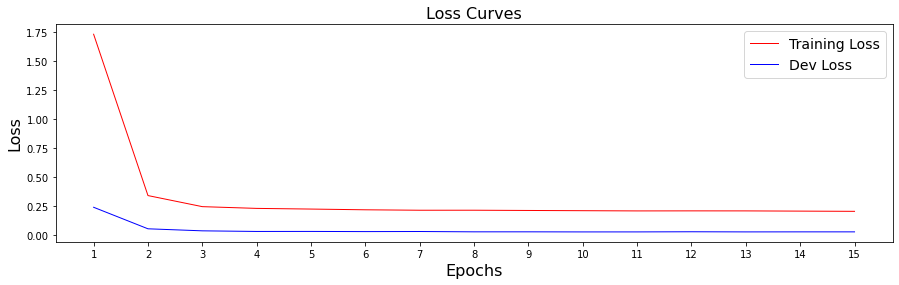

In [22]:
%matplotlib inline
plt.figure(figsize=[15, 4])
plt.plot(loss_df['TRAIN_LOSS'], 'r', linewidth=1.0)
plt.plot(loss_df['DEV_LOSS'], 'b', linewidth=1.0)
plt.xticks([epoch-1 for epoch in loss_df['EPOCH']], labels = [str(epoch) for epoch in loss_df['EPOCH']])
plt.legend(['Training Loss', 'Dev Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Loss Curves', fontsize=16);

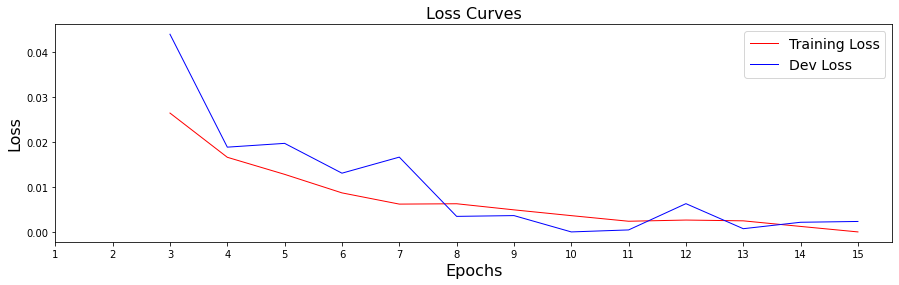

In [23]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

loss_df["DEV_LOSS_SCALED"] = scaler.fit_transform(loss_df[["DEV_LOSS"]])
loss_df["TRAIN_LOSS_SCALED"] = scaler.fit_transform(loss_df[["TRAIN_LOSS"]])

plt.figure(figsize=[15, 4])
plt.plot(loss_df['TRAIN_LOSS_SCALED'][2:15], 'r', linewidth=1.0)
plt.plot(loss_df['DEV_LOSS_SCALED'][2:15], 'b', linewidth=1.0)
plt.xticks([epoch-1 for epoch in loss_df['EPOCH']], labels = [str(epoch) for epoch in loss_df['EPOCH']])
plt.legend(['Training Loss', 'Dev Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Loss Curves', fontsize=16);

In [24]:
model = SequenceTagger.load(os.path.join(model_dir_path, 'best-model.pt'))

2025-02-06 18:50:49,518 loading file logs/GELECTRA/NER/10K/k5/best-model.pt
2025-02-06 18:51:42,197 SequenceTagger predicts: Dictionary with 57 tags: O, S-MALE, B-MALE, E-MALE, I-MALE, S-FAMILY, B-FAMILY, E-FAMILY, I-FAMILY, S-URL, B-URL, E-URL, I-URL, S-EMAIL, B-EMAIL, E-EMAIL, I-EMAIL, S-PHONE, B-PHONE, E-PHONE, I-PHONE, S-CITY, B-CITY, E-CITY, I-CITY, S-DATE, B-DATE, E-DATE, I-DATE, S-STREET, B-STREET, E-STREET, I-STREET, S-ZIP, B-ZIP, E-ZIP, I-ZIP, S-STREETNO, B-STREETNO, E-STREETNO, I-STREETNO, S-FEMALE, B-FEMALE, E-FEMALE, I-FEMALE, S-UFID, B-UFID, E-UFID, I-UFID, S-ORG


In [25]:
# run evaluation procedure
result = model.evaluate(corpus.test, mini_batch_size=4, out_path=f"predictions.txt", gold_label_type="ner")
print(result.detailed_results)

100%|█████████████████████████████████████████| 500/500 [01:35<00:00,  5.26it/s]

2025-02-06 18:53:17,782 Evaluating as a multi-label problem: False

Results:
- F-score (micro) 0.9852
- F-score (macro) 0.9728
- Accuracy 0.9746

By class:
              precision    recall  f1-score   support

        MALE     0.9941    0.9948    0.9944      2690
      FAMILY     0.9877    0.9899    0.9888      1789
         URL     0.9786    0.9841    0.9813      1067
       EMAIL     0.9978    1.0000    0.9989       890
       PHONE     0.9808    0.9922    0.9865       773
        CITY     0.9897    0.9830    0.9863       587
        DATE     0.9854    0.9937    0.9895       476
      STREET     0.9968    1.0000    0.9984       309
         ZIP     1.0000    0.9932    0.9966       295
    STREETNO     0.9755    0.9894    0.9824       282
      FEMALE     0.9792    0.9671    0.9731       243
         ORG     0.7845    0.8273    0.8053       220
        UFID     0.9414    0.9766    0.9587       214
        USER     0.9592    1.0000    0.9792        47

   micro avg     0.9830    0.987